In [1]:
# Loading the packages
import requests 
import json
from elasticsearch import Elasticsearch
import creds
from tqdm.auto import tqdm
from openai import OpenAI
import tiktoken

Q1: What's the `version.build_hash` value?

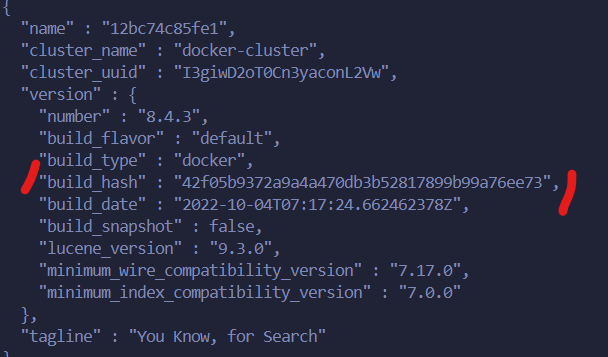
- The build_hash is: 42f05b9372a9a4a470db3b52817899b99a76ee73

In [2]:
# Getting the data
docs_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main/01-intro/documents.json?raw=1'
docs_response = requests.get(docs_url)
documents_raw = docs_response.json()

documents = []

for course in documents_raw:
    course_name = course['course']

    for doc in course['documents']:
        doc['course'] = course_name
        documents.append(doc)

In [3]:
# Defining the elastic search client
es_client = Elasticsearch('http://localhost:9200')
index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            # "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"} 
        }
    }
}
index_name = 'course-questions'
es_client.indices.create(index=index_name, body=index_settings)

for doc in tqdm(documents):
    es_client.index(index=index_name, document=doc) # Data is getting added at this stage

  0%|          | 0/948 [00:00<?, ?it/s]

Q2: Which function do you use for adding your data to elastic?
- Index

In [4]:
# Function creating the elastic search client
def elastic_search(size, query, filter):
    search_query = {
        "size": size,
        "query": {
            "bool": {
                "must": {
                    "multi_match": {
                        "query": query,
                        "fields": ["question^4", "text"],
                        "type": "best_fields"
                    }
                },
                "filter": filter
            }
        }
    }
    response = es_client.search(index=index_name, body=search_query)
    result_docs = []
    result_scores = []    
    for hit in response['hits']['hits']:
        result_docs.append(hit['_source'])
        result_scores.append(hit['_score']) 
    return result_docs, result_scores


In [5]:
_, result_scores = elastic_search(size = 5, query='How do execute a command on a Kubernetes pod?', filter=None)
print(f'The max score is: {round(max(result_scores), 2)}')

The max score is: 44.51


Q3: What's the score for the top ranking result?
- 44.50

In [6]:
ml_filter = {"term": {"course": "machine-learning-zoomcamp"}}
result_docs_2, _ = elastic_search(size = 3, query='How do copy a file to a Docker container?', filter=ml_filter)
print(f'The third question returned by the search engine is:\n{result_docs_2[2]["question"]}')

The third question returned by the search engine is:
How do I copy files from a different folder into docker container’s working directory?


Q4: Return 3 results. What's the 3rd question returned by the search engine?
- How do I copy files from a different folder into docker container’s working directory?

In [7]:
# Function to format the top results into a readable context string
def create_context(results):
    context = ""
    for doc in results:
        context = context + f"""Q: {doc['question']}\nA: {doc['text']}\n\n"""
    return context

# Function to construct a prompt for the AI using the query and the search context
def create_prompt(query, context):
    prompt_template = '''
You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
Use only the facts from the CONTEXT when answering the QUESTION.

QUESTION: {question}

CONTEXT:
{context}
'''.strip()

    # Formatting the template with the actual query and context
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

context = create_context(results=result_docs_2)
prompt = create_prompt(query='How do copy a file to a Docker container?', context=context)
print(f"The length of the prompt is: {len(prompt)}")

The length of the prompt is: 1446


Q5: What's the length of the resulting prompt? (use the `len` function)
- 1446

In [8]:
encoding = tiktoken.encoding_for_model("gpt-4o")
print(f'The number of tokens our prompt has is: {len(encoding.encode(prompt))}')

The number of tokens our prompt has is: 320


Use the `encode` function. How many tokens does our prompt have?
- 320